In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import folium
import openpyxl
import seaborn as sns
import re
import datetime as dt
from datetime import timedelta
%matplotlib inline

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [2]:
#read in the data

members = pd.read_csv('data/NSS_GreatCare_Members.csv')
hosp_admish = pd.read_csv('data/NSS_Hospital_Inpatient_Admissions.csv')
pc_visits = pd.read_csv('data/NSS_PrimaryCare_Office_Visits.csv', low_memory=False)

In [3]:
pc_visits.head()
pc_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231373 entries, 0 to 231372
Data columns (total 18 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Encounter ID                                   231373 non-null  object 
 1   Patient ID                                     231373 non-null  object 
 2   Service Provider ID                            230599 non-null  object 
 3   Attending Provider ID                          39644 non-null   object 
 4   Provider Group Provider ID                     227644 non-null  object 
 5   Facility Provider ID                           39756 non-null   object 
 6   Encounter Primary Payor ID                     231373 non-null  object 
 7   Encounter Primary Plan ID                      231373 non-null  object 
 8   Attending Provider NPI                         39644 non-null   float64
 9   Facility Provider NPI                

In [4]:
hosp_admish.head()
#hosp_admish.info()

Encounter ID Patient ID Encounter Primary Payor ID  \
0  HIA|DS1|10033|DS1|NPI|1306890389|1  DS1|10033                      DS1|1   
1  HIA|DS1|10043|DS1|NPI|1902803315|1  DS1|10043                      DS1|1   
2  HIA|DS1|10073|DS1|NPI|1902803315|1  DS1|10073                      DS1|1   
3  HIA|DS1|10101|DS1|NPI|1427055839|1  DS1|10101                      DS1|1   
4  HIA|DS1|10118|DS1|NPI|1992818256|1  DS1|10118                      DS1|1   

  Encounter Primary Plan ID Facility Provider ID Attending Provider ID  \
0                 DS1|5047W   DS1|NPI|1306890389    DS1|NPI|1417170523   
1                 DS1|5047Y   DS1|NPI|1902803315    DS1|NPI|1669599197   
2                 DS1|5047X   DS1|NPI|1902803315    DS1|NPI|1407880511   
3                 DS1|5047W   DS1|NPI|1427055839    DS1|NPI|1407008907   
4                 DS1|5047W   DS1|NPI|1992818256    DS1|NPI|1518045608   

   Attending Provider NPI Facility Provider NPI Encounter Start Date  \
0            1.417171e+09            1306890389           2013-01-12   
1            1.669599e+09            1902803315           2014-01-05   
2            1.407881e+09            1902803315           2012-06-13   
3            1.407009e+09            1427055839           2012-12-06   
4            1.518046e+09            1992818256           2015-03-11   

  Encounter End Date  Is Emergency Department Visit Parent Encounter  \
0         2013-01-14                                               0   
1         2014-01-12                                               0   
2         2012-06-21                                               1   
3         2012-12-09                                               0   
4         2015-03-14                                               0   

   Is Observation Stay Parent Encounter  CMS Admit Type Code  \
0                                     0                  1.0   
1                                     0                  3.0   
2                                     0                  1.0   
3                                     0                  3.0   
4                                     0                  2.0   

  CMS Admit Source Code  CMS Patient Discharge Status Code  \
0                     1                                  1   
1                     1                                  1   
2                     1                                  1   
3                     1                                  1   
4                     2                                  1   

   CMS Place of Service Code Principal Discharge Diagnosis ICD-9-CM Code  \
0                       21.0                                         NaN   
1                       21.0                                       348.4   
2                       21.0                                         NaN   
3                       21.0                                         NaN   
4                        NaN                                         NaN   

  Principal Discharge Diagnosis ICD-9-CM Description  \
0                                                NaN   
1                               Compression of brain   
2                                                NaN   
3                                                NaN   
4                                                NaN   

  Principal Discharge Diagnosis ICD-10-CM Code  \
0                                        O70.0   
1                                          NaN   
2                                       K91.71   
3                                        O70.1   
4                                        F32.9   

  Principal Discharge Diagnosis ICD-10-CM Description  \
0   First degree perineal laceration during delivery    
1                                                NaN    
2  Accidental puncture and laceration of a digest...    
3  Second degree perineal laceration during delivery    
4  Major depressive disorder, single episode, uns...    

   Primary Plan Allowed Amount  Primary Pla

In [5]:
members
#members.info()

Patient ID Primary Plan ID Primary Payor ID  Is Patient Alive  \
0          DS1|1       DS1|5047W            DS1|1                 1   
1         DS1|10       DS1|5047W            DS1|1                 1   
2        DS1|100       DS1|5047W            DS1|1                 1   
3       DS1|1000       DS1|5047W            DS1|1                 1   
4      DS1|10000       DS1|5047W            DS1|1                 1   
...          ...             ...              ...               ...   
61514   DS1|9995       DS1|5047W            DS1|1                 1   
61515   DS1|9996       DS1|5047X            DS1|1                 1   
61516   DS1|9997       DS1|5047W            DS1|1                 1   
61517   DS1|9998       DS1|5047X            DS1|1                 1   
61518   DS1|9999       DS1|5047X            DS1|1                 1   

       Patient Age Integer Patient Date of Birth  Patient ZIP Code 5-Digit  \
0                       54            1958-11-08                   92111.0   
1                       54            1958-12-10                   90024.0   
2                        2            2012-08-04                   90008.0   
3                        6            2003-12-25                   94131.0   
4                        7            2005-07-15                   90301.0   
...                    ...                   ...                       ...   
61514                   47            1963-07-26                   92104.0   
61515                   26            1983-04-17                   94122.0   
61516                    4            2008-12-11                   92840.0   
61517                   63            1954-05-23                   94939.0   
61518                   41            1973-07-08                   90024.0   

       Count Primary Care Visits in Last 36 Months  \
0                                                0   
1                                                6   
2                                                1   
3                                                0   
4                                                0   
...                                            ...   
61514                                            0   
61515                                            0   
61516                                            1   
61517                                            1   
61518                                            3   

       Count Visits with Attributee Individual Primary Care Provider i  \
0                                                    NaN                 
1                                                    1.0                 
2                                                    1.0                 
3                                                    NaN                 
4                                                    NaN                 
...                                                  ...                 
61514                                                NaN                 
61515                                                NaN                 
61516                                                1.0                 
61517                                                1.0                 
61518                                                2.0                 

       Count Visits with Attributee Primary Care Provider Group in Las  \
0                                                    NaN                 
1                                                    5.0                 
2                                                    1.0                 
3                                                    NaN                 
4                                                    NaN                 
...                                                  ...                 
61514                                                NaN                 
61515                                                NaN                 
61516       

### 1. What is our 30-day all cause readmission rate across hospitals our members are admitted to?

In [6]:
#look at start and end date of all hospital visits. drop irrelevant columns, count admissions for denominator (6,213)
hosp_stay = hosp_admish[['Patient ID','Encounter Start Date','Encounter End Date',
                         'Attending Provider NPI','Facility Provider NPI']]

#convert dates from objects to datetimes, convert floats to objects
hosp_stay.loc[:,['Encounter Start Date','Encounter End Date']] = hosp_stay.loc[:,['Encounter Start Date','Encounter End Date']].apply(pd.to_datetime)
hosp_stay = hosp_stay.astype({'Attending Provider NPI':object})

# hosp_stay.head()
hosp_stay.info()
#hosp_stay.count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6213 entries, 0 to 6212
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Patient ID              6213 non-null   object        
 1   Encounter Start Date    6213 non-null   datetime64[ns]
 2   Encounter End Date      6213 non-null   datetime64[ns]
 3   Attending Provider NPI  5884 non-null   object        
 4   Facility Provider NPI   6213 non-null   object        
dtypes: datetime64[ns](2), object(3)
memory usage: 242.8+ KB


C:\Users\rgher\anaconda\lib\site-packages\pandas\core\indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [7]:
#if using the unique patients admitted as denominator, drop duplicate patients and count rows (4,701 unique patients)
# num_patients = hosp_stay.drop_duplicates('Patient ID')
# num_patients.count()

In [8]:
#group by patient ID and filter out any patients under 2 visits

readmish = hosp_stay.groupby('Patient ID')['Encounter Start Date'].count().reset_index()
readmish = readmish[readmish['Encounter Start Date'] >= 2]
readmish.rename({'Encounter Start Date':'# of admissions'}, axis=1)

Patient ID  # of admissions
8     DS1|10132                2
17    DS1|10253                3
18    DS1|10291                2
32    DS1|10451               12
37    DS1|10507                2
...         ...              ...
4679   DS1|9809                2
4683   DS1|9864                2
4690   DS1|9935                3
4692   DS1|9943                3
4699   DS1|9994                2

[870 rows x 2 columns]

In [9]:
#filter hospital stay to patients with more than one stay (from readmish table). DEBBIE'S GENIUS CODE TO CREATE NEW COLUMN
#THAT TAKES PATIENT'S NEXT START DATE AND ADDS IT TO SAME LINE AS PREVIOUS VISIT
multistay = hosp_stay[hosp_stay['Patient ID'].isin(readmish['Patient ID'])]
multistay['Next Start Date'] = multistay.sort_values('Encounter Start Date',ascending=True).groupby('Patient ID')['Encounter Start Date'].shift(-1)
multistay

<ipython-input-9-95faf4484be2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multistay['Next Start Date'] = multistay.sort_values('Encounter Start Date',ascending=True).groupby('Patient ID')['Encounter Start Date'].shift(-1)


Patient ID Encounter Start Date Encounter End Date  \
7     DS1|10132           2013-08-14         2013-08-16   
8     DS1|10132           2013-03-30         2013-04-01   
17    DS1|10253           2011-10-15         2011-11-13   
18    DS1|10253           2010-06-02         2010-06-06   
19    DS1|10253           2010-04-02         2010-04-16   
...         ...                  ...                ...   
6201   DS1|9943           2013-10-01         2013-10-16   
6202   DS1|9943           2013-10-25         2013-10-28   
6203   DS1|9943           2014-10-28         2014-10-30   
6210   DS1|9994           2015-11-21         2015-11-23   
6211   DS1|9994           2015-11-24         2015-11-27   

     Attending Provider NPI Facility Provider NPI Next Start Date  
7                       NaN            1366545311             NaT  
8              1417995317.0            1386741635      2013-08-14  
17             1750346474.0            1215987532             NaT  
18             1932127248.0            1396725677      2011-10-15  
19             1346566221.0            1689772592      2010-06-02  
...                     ...                   ...             ...  
6201           1932297231.0            1184722779      2013-10-25  
6202           1942320288.0            1184722779      2014-10-28  
6203           1265649966.0            1184722779             NaT  
6210           1861831836.0            1689608150      2015-11-24  
6211           1750544516.0            1689608150             NaT  

[2382 rows x 6 columns]

In [10]:
#subtract next start date from last end date and create new column for these results
multistay['Days Between'] = multistay['Next Start Date'] - multistay['Encounter End Date']
multistay

<ipython-input-10-2e82419d3d6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multistay['Days Between'] = multistay['Next Start Date'] - multistay['Encounter End Date']


Patient ID Encounter Start Date Encounter End Date  \
7     DS1|10132           2013-08-14         2013-08-16   
8     DS1|10132           2013-03-30         2013-04-01   
17    DS1|10253           2011-10-15         2011-11-13   
18    DS1|10253           2010-06-02         2010-06-06   
19    DS1|10253           2010-04-02         2010-04-16   
...         ...                  ...                ...   
6201   DS1|9943           2013-10-01         2013-10-16   
6202   DS1|9943           2013-10-25         2013-10-28   
6203   DS1|9943           2014-10-28         2014-10-30   
6210   DS1|9994           2015-11-21         2015-11-23   
6211   DS1|9994           2015-11-24         2015-11-27   

     Attending Provider NPI Facility Provider NPI Next Start Date Days Between  
7                       NaN            1366545311             NaT          NaT  
8              1417995317.0            1386741635      2013-08-14     135 days  
17             1750346474.0            1215987532             NaT          NaT  
18             1932127248.0            1396725677      2011-10-15     496 days  
19             1346566221.0            1689772592      2010-06-02      47 days  
...                     ...                   ...             ...          ...  
6201           1932297231.0            1184722779      2013-10-25       9 days  
6202           1942320288.0            1184722779      2014-10-28     365 days  
6203           1265649966.0            1184722779             NaT          NaT  
6210           1861831836.0            1689608150      2015-11-24       1 days  
6211           1750544516.0            1689608150             NaT          NaT  

[2382 rows x 7 columns]

In [11]:
#create another column to define whether 'Days Between' is less than 30 or not. Used Teng's for loop

t = []

for i in multistay['Days Between']:
    if (i <= dt.timedelta(days=30)) and (i >= dt.timedelta(days=0)) :
        t.append('yes')
    else:
        t.append('no')

multistay['Under 30 Days'] = t
multistay

<ipython-input-11-7a47abd84312>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multistay['Under 30 Days'] = t


Patient ID Encounter Start Date Encounter End Date  \
7     DS1|10132           2013-08-14         2013-08-16   
8     DS1|10132           2013-03-30         2013-04-01   
17    DS1|10253           2011-10-15         2011-11-13   
18    DS1|10253           2010-06-02         2010-06-06   
19    DS1|10253           2010-04-02         2010-04-16   
...         ...                  ...                ...   
6201   DS1|9943           2013-10-01         2013-10-16   
6202   DS1|9943           2013-10-25         2013-10-28   
6203   DS1|9943           2014-10-28         2014-10-30   
6210   DS1|9994           2015-11-21         2015-11-23   
6211   DS1|9994           2015-11-24         2015-11-27   

     Attending Provider NPI Facility Provider NPI Next Start Date  \
7                       NaN            1366545311             NaT   
8              1417995317.0            1386741635      2013-08-14   
17             1750346474.0            1215987532             NaT   
18             1932127248.0            1396725677      2011-10-15   
19             1346566221.0            1689772592      2010-06-02   
...                     ...                   ...             ...   
6201           1932297231.0            1184722779      2013-10-25   
6202           1942320288.0            1184722779      2014-10-28   
6203           1265649966.0            1184722779             NaT   
6210           1861831836.0            1689608150      2015-11-24   
6211           1750544516.0            1689608150             NaT   

     Days Between Under 30 Days  
7             NaT            no  
8        135 days            no  
17            NaT            no  
18       496 days            no  
19        47 days            no  
...           ...           ...  
6201       9 days           yes  
6202     365 days            no  
6203          NaT            no  
6210       1 days           yes  
6211          NaT            no  

[2382 rows x 8 columns]

In [12]:
#Why doesn't this work?
# thirty_dict = {dt.timedelta(days<=30):'yes',dt.timedelta(days>30):'no'}

# multistay['Under 30 Days'] = multistay['Days Between'].map(thirty_dict)
# multistay

In [13]:
#count yes, use as numerator to calculate rate of <30 Day Readmission
yes = len(multistay[multistay['Under 30 Days']=='yes']) 
#yes

total_admish = len(hosp_stay)
total_admish

6213

In [14]:
#calculate the rate
rate_under_30days = round((yes/total_admish)*100,2)
rate_under_30days

11.2

In [15]:
#for potential other exploration, identify the members who have had under 30-day readmissions
in_readmission = multistay[multistay['Under 30 Days']=='yes']
in_readmission.head()

Patient ID Encounter Start Date Encounter End Date Attending Provider NPI  \
34  DS1|10451           2014-04-24         2014-04-26           1306902739.0   
35  DS1|10451           2013-03-20         2013-03-23           1518963032.0   
37  DS1|10451           2013-04-16         2013-04-26           1427344951.0   
39  DS1|10451           2013-06-25         2013-07-01           1073566931.0   
40  DS1|10451           2013-07-26         2013-08-03           1679541775.0   

   Facility Provider NPI Next Start Date Days Between Under 30 Days  
34            1023010113      2014-05-23      27 days           yes  
35            1063412005      2013-03-27       4 days           yes  
37            1427055839      2013-05-01       5 days           yes  
39            1427055839      2013-07-26      25 days           yes  
40            1427055839      2013-08-31      28 days           yes

### 0 Day Exploration

In [16]:
#How many of these are 0 days? Enough to make a difference?
zero_days = in_readmission[in_readmission['Days Between'] == dt.timedelta(days=0)]
len(zero_days)

122

In [17]:
#IS THIS A LOT?
rate_zero_days = round((len(zero_days)/len(in_readmission))*100,2)
rate_zero_days

17.53

In [186]:
zero_days

zero_by_hosp = zero_days.groupby('Facility Provider NPI')['Patient ID'].count().reset_index().sort_values('Patient ID',ascending=False)
zero_by_hosp = zero_by_hosp.rename({'Patient ID':'Count of 0 Day','Facility Provider NPI':'Hospital'},axis=1)
#zero_by_hosp['Percentage'] = round((zero_by_hosp['Count of 0 Day']/zero_by_hosp['Count of Readmissions'].sum())*100,2)
zero_by_hosp.head(10)

Hospital  Count of 0 Day
55  1902803315              17
44  1710918545              12
24  1427055839               9
12  1184722779               7
0   0000000000               4
38  1689772592               4
3   1033298617               3
22  1407839921               3
52  1841277704               3
51  1811080526               2

In [199]:
#zero day rates by hospital

zero_rates = read_by_hospital.merge(zero_by_hosp, on='Hospital', how='left')\
            .drop(columns='Percentage of Readmissions Under 30 Days')

zero_rates['Percentage'] = round((zero_rates['Count of 0 Day']/zero_rates['Count of Readmissions']*100),2)
zero_rates.sort_values('Percentage', ascending=False)


Hospital  Count of Readmissions  Count of 0 Day  Percentage
36  1053351916                      2             2.0      100.00
38  1124073366                      1             1.0      100.00
42  1073665360                      1             1.0      100.00
43  1760424261                      1             1.0      100.00
46  1790778488                      1             1.0      100.00
48  1366401333                      1             1.0      100.00
50  1700829199                      1             1.0      100.00
51  1861439952                      1             1.0      100.00
53  1891938122                      1             1.0      100.00
54  1043215379                      1             1.0      100.00
57  1962407460                      1             1.0      100.00
58  1962568337                      1             1.0      100.00
61  1124098421                      1             1.0      100.00
62  1396728630                      1             1.0      100.00
63  1689984668                      1             1.0      100.00
65  1316938301                      1             1.0      100.00
66  1306890389                      1             1.0      100.00
68  1447335146                      1             1.0      100.00
69  1457321317                      1             1.0      100.00
70  1275591984                      1             1.0      100.00
71  1477554152                      1             1.0      100.00
75  1013062769                      1             1.0      100.00
76  1528041811                      1             1.0      100.00
77  1538265780                      1             1.0      100.00
78  1548393127                      1             1.0      100.00
79  1578529285                      1             1.0      100.00
80  1629011945                      1             1.0      100.00
82  1194840421                      1             1.0      100.00
83  1194774299                      1             1.0      100.00
40  1114971660                      1             1.0      100.00
86  1679816201                      1             1.0      100.00
24  1699868398                      2             2.0      100.00
16  1841277704                      3             3.0      100.00
17  1407839921                      3             3.0      100.00
28  1417089350                      2             2.0      100.00
21  1750491247                      2             2.0      100.00
26  1376513754                      2             2.0      100.00
20  1700804200                      3             2.0       66.67
11  1811080526                      4             2.0       50.00
12  1265814065                      4             2.0       50.00
35  1043502750                      2             1.0       50.00
23  1659359446                      2             1.0       50.00
22  1942269725                      2             1.0       50.00
25  1639172133                      2             1.0       50.00
27  1730238007                      2             1.0       50.00
29  1740348929                      2             1.0       50.00
30  1902844988                      2             1.0       50.00
31  1518951300                      2             1.0       50.00
32  1134564693                      2             1.0       50.00
34  1023065729                      2             1.0       50.00
15  1770532608                      3             1.0       33.33
7   0000000000                     13             4.0       30.77
13  1639172372                      4             1.0       25.00
4   1710918545                     50            12.0       24.00
2   1902803315                    101            17.0       16.83
9   1710065933                      9             1.0       11.11
8   1992818256                     10             1.0       10.00
1   1427055839                    107             9.0        8.41
5   1033298617                     43             3.0        6.98
0   1184722779                    115         

In [209]:
zero_rates_above_10 = zero_rates[zero_rates['Count of Readmissions'] >=7]
zero_rates_above_10 = zero_rates_above_10.sort_values('Percentage',ascending=False)

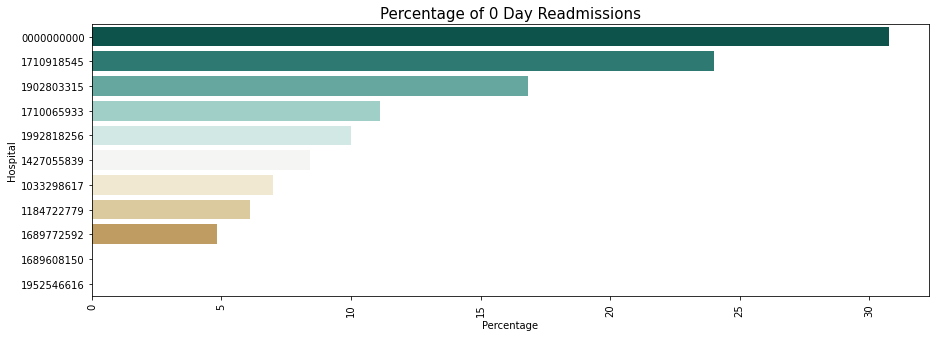

In [224]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(data=zero_rates_above_10, y='Hospital', x='Percentage', palette="BrBG_r")
plt.title('Percentage of 0 Day Readmissions' , color = 'black', fontsize=15)
plt.xticks(rotation=90);

plt.savefig('percentage of 0 day readmissions', transparent = True);

### 1a. Rate per Month

In [19]:
#oldest and newest end dates for reference
hosp_stay_rec = hosp_stay[hosp_stay['Encounter End Date'] == hosp_stay['Encounter End Date'].max()]
hosp_stay_rec

Patient ID Encounter Start Date Encounter End Date  \
3470  DS1|40578           2019-04-28         2019-05-01   

     Attending Provider NPI Facility Provider NPI  
3470           1295062321.0            1033298617

In [130]:
hosp_stay_old = hosp_stay[hosp_stay['Encounter End Date'] == hosp_stay['Encounter End Date'].min()]
hosp_stay_old

Patient ID Encounter Start Date Encounter End Date Attending Provider NPI  \
77  DS1|10734           2009-11-11         2009-11-25           1629382395.0   

   Facility Provider NPI Month/Year  
77            1104982917    2009-11

In [162]:
#group hosp_stay by month to see admissions by month. First add a column that lists month & year
hosp_stay['Month/Year'] = hosp_stay['Encounter End Date'].dt.to_period('M')
hosp_stay

Patient ID Encounter Start Date Encounter End Date  \
0     DS1|10033           2013-01-12         2013-01-14   
1     DS1|10043           2014-01-05         2014-01-12   
2     DS1|10073           2012-06-13         2012-06-21   
3     DS1|10101           2012-12-06         2012-12-09   
4     DS1|10118           2015-03-11         2015-03-14   
5     DS1|10126           2010-04-07         2010-04-09   
6     DS1|10130           2014-06-01         2014-06-05   
7     DS1|10132           2013-08-14         2013-08-16   
8     DS1|10132           2013-03-30         2013-04-01   
9     DS1|10135           2013-08-20         2013-08-22   
10    DS1|10168           2014-12-17         2014-12-19   
11    DS1|10169           2013-05-13         2013-05-18   
12    DS1|10191           2010-12-24         2010-12-28   
13    DS1|10193           2014-05-23         2014-05-23   
14    DS1|10228           2015-02-03         2015-02-07   
15    DS1|10239           2014-05-09         2014-05-15   
16    DS1|10244           2014-08-26         2014-08-29   
17    DS1|10253           2011-10-15         2011-11-13   
18    DS1|10253           2010-06-02         2010-06-06   
19    DS1|10253           2010-04-02         2010-04-16   
20    DS1|10291           2010-05-14         2010-05-15   
21    DS1|10291           2011-02-24         2011-03-05   
22    DS1|10296           2014-02-12         2014-02-13   
23    DS1|10303           2012-06-21         2012-06-24   
24    DS1|10305           2014-05-10         2014-05-12   
25    DS1|10325           2012-07-06         2012-07-07   
26    DS1|10343           2010-02-23         2010-03-03   
27    DS1|10349           2017-06-21         2017-06-22   
28    DS1|10375           2014-08-15         2014-08-18   
29    DS1|10399           2014-09-25         2014-10-03   
30    DS1|10411           2015-02-24         2015-02-26   
31    DS1|10415           2012-08-19         2012-08-20   
32    DS1|10423           2014-12-24         2014-12-27   
33    DS1|10436           2015-02-20         2015-02-23   
34    DS1|10451           2014-04-24         2014-04-26   
35    DS1|10451           2013-03-20         2013-03-23   
36    DS1|10451           2014-06-29         2014-06-29   
37    DS1|10451           2013-04-16         2013-04-26   
38    DS1|10451           2013-05-01         2013-05-09   
39    DS1|10451           2013-06-25         2013-07-01   
40    DS1|10451           2013-07-26         2013-08-03   
41    DS1|10451           2013-08-31         2013-09-02   
42    DS1|10451           2013-11-14         2013-11-20   
43    DS1|10451           2013-12-17         2013-12-19   
44    DS1|10451           2014-05-23         2014-05-29   
45    DS1|10451           2013-03-27         2013-04-16   
46    DS1|10452           2014-12-17         2014-12-20   
47    DS1|10453           2013-07-17         2013-07-20   
48     DS1|1045           2012-10-25         2012-10-26   
49    DS1|10494           2016-11-27         2016-11-29   
50    DS1|10503           2014-11-03         2014-11-05   
51    DS1|10507           2012-11-10         2012-11-16   
52    DS1|10507           2012-11-20         2012-11-27   
53    DS1|10509           2014-02-28         2014-03-02   
54    DS1|10515           2018-08-06         2018-08-09   
55    DS1|10520           2011-07-07         2011-07-10   
56    DS1|10522           2012-10-31         2012-11-02   
57    DS1|10529           2012-09-04         2012-09-05   
58    DS1|10535           2012-11-21         2012-11-23   
59    DS1|10544           2012-10-10         2012-10-15   
60    DS1|10598           2011-03-28         2011-03-31   
61     DS1|1060           2014-04-17         2014-04-21   
62    DS1|10624           2010-10-18         2010-10-20   
63    DS1|10666           2011-09-04         2011-09-06   
64    DS1|10674           2014-09-28         2014-09-30   
65    DS1|10698           2012-01-04         2012-01-05   
66    DS1|10698           2012-01-03         2012-01

In [22]:
#group admissions into month buckets
monthly_stay_count = hosp_stay.groupby('Month/Year')['Patient ID'].count().reset_index()
monthly_stay_count = monthly_stay_count.rename({'Patient ID':'Admission Count'}, axis=1)
monthly_stay_count

Month/Year  Admission Count
0      2009-11                2
1      2009-12               26
2      2010-01               45
3      2010-02               30
4      2010-03               31
..         ...              ...
109    2018-12                1
110    2019-01                1
111    2019-02                4
112    2019-04                1
113    2019-05                1

[114 rows x 2 columns]

In [23]:
#same steps as above to calculate readmissions under 30 days on monthly basis. SHOULD THIS BE BASED ON END DATE OR NEXT ADMISH??
in_readmission['Month/Year'] = in_readmission['Encounter End Date'].dt.to_period('M')
in_readmission

<ipython-input-23-05e16de6738d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_readmission['Month/Year'] = in_readmission['Encounter End Date'].dt.to_period('M')


Patient ID Encounter Start Date Encounter End Date  \
34    DS1|10451           2014-04-24         2014-04-26   
35    DS1|10451           2013-03-20         2013-03-23   
37    DS1|10451           2013-04-16         2013-04-26   
39    DS1|10451           2013-06-25         2013-07-01   
40    DS1|10451           2013-07-26         2013-08-03   
...         ...                  ...                ...   
6184   DS1|9809           2013-01-09         2013-01-11   
6198   DS1|9935           2011-01-22         2011-01-24   
6199   DS1|9935           2011-01-25         2011-01-26   
6201   DS1|9943           2013-10-01         2013-10-16   
6210   DS1|9994           2015-11-21         2015-11-23   

     Attending Provider NPI Facility Provider NPI Next Start Date  \
34             1306902739.0            1023010113      2014-05-23   
35             1518963032.0            1063412005      2013-03-27   
37             1427344951.0            1427055839      2013-05-01   
39             1073566931.0            1427055839      2013-07-26   
40             1679541775.0            1427055839      2013-08-31   
...                     ...                   ...             ...   
6184           1982836466.0            1689608150      2013-01-20   
6198           1376864215.0            1669456299      2011-01-25   
6199           1972545085.0            1902803315      2011-01-26   
6201           1932297231.0            1184722779      2013-10-25   
6210           1861831836.0            1689608150      2015-11-24   

     Days Between Under 30 Days Month/Year  
34        27 days           yes    2014-04  
35         4 days           yes    2013-03  
37         5 days           yes    2013-04  
39        25 days           yes    2013-07  
40        28 days           yes    2013-08  
...           ...           ...        ...  
6184       9 days           yes    2013-01  
6198       1 days           yes    2011-01  
6199       0 days           yes    2011-01  
6201       9 days           yes    2013-10  
6210       1 days           yes    2015-11  

[696 rows x 9 columns]

In [25]:
#group readmissions into month buckets
monthly_read_count = in_readmission.groupby('Month/Year')['Patient ID'].count().reset_index()
monthly_read_count = monthly_read_count.rename({'Patient ID':'Readmission Count'}, axis=1)
monthly_read_count

Month/Year  Readmission Count
0     2009-12                  6
1     2010-01                  3
2     2010-03                  3
3     2010-04                 10
4     2010-05                  4
..        ...                ...
90    2017-09                  3
91    2018-01                  1
92    2018-03                  1
93    2018-04                  1
94    2018-05                  1

[95 rows x 2 columns]

In [175]:
#combine admission and readmission counts per month in new df and create new column for monthly rate
rate_per_month = monthly_stay_count.merge(monthly_read_count, on='Month/Year', how='left')
rate_per_month['Admission Count'] = rate_per_month['Admission Count'].astype(float)

#HOW TO CONVERT FROM PERIOD TO OBJECT I CAN PLOT OVER TIME?
#rate_per_month['Month/Year'] = rate_per_month['Month/Year'].astype(object).pd.to_timestamp()

rate_per_month['Under 30 Rate'] = round((rate_per_month['Readmission Count']/rate_per_month['Admission Count'])*100,2)
rate_per_month.sort_values('Under 30 Rate', ascending=False)
# rate_per_month.info()

Month/Year  Admission Count  Readmission Count  Under 30 Rate
98     2018-01              2.0                1.0          50.00
101    2018-04              3.0                1.0          33.33
94     2017-09             11.0                3.0          27.27
93     2017-08             11.0                3.0          27.27
87     2017-02             22.0                6.0          27.27
89     2017-04             19.0                5.0          26.32
86     2017-01             20.0                5.0          25.00
1      2009-12             26.0                6.0          23.08
88     2017-03             13.0                3.0          23.08
102    2018-05              5.0                1.0          20.00
5      2010-04             51.0               10.0          19.61
82     2016-09             31.0                6.0          19.35
19     2011-06             64.0               11.0          17.19
77     2016-04             36.0                6.0          16.67
76     2016-03             49.0                8.0          16.33
14     2011-01             62.0               10.0          16.13
58     2014-09             84.0               13.0          15.48
27     2012-02             94.0               14.0          14.89
66     2015-05             74.0               11.0          14.86
52     2014-03            115.0               17.0          14.78
28     2012-03             99.0               14.0          14.14
54     2014-05            114.0               16.0          14.04
34     2012-09             72.0               10.0          13.89
50     2014-01            116.0               16.0          13.79
61     2014-12             87.0               12.0          13.79
6      2010-05             29.0                4.0          13.79
39     2013-02            116.0               16.0          13.79
47     2013-10             81.0               11.0          13.58
32     2012-07             96.0               13.0          13.54
75     2016-02             38.0                5.0          13.16
16     2011-03             77.0               10.0          12.99
36     2012-11             85.0               11.0          12.94
35     2012-10             93.0               12.0          12.90
44     2013-07            102.0               13.0          12.75
29     2012-04             95.0               12.0          12.63
30     2012-05            112.0               14.0          12.50
84     2016-11             16.0                2.0          12.50
8      2010-07             41.0                5.0          12.20
49     2013-12            115.0               14.0          12.17
25     2011-12             74.0                9.0          12.16
70     2015-09             66.0                8.0          12.12
48     2013-11             67.0                8.0          11.94
9      2010-08             42.0                5.0          11.90
21     2011-08             59.0                7.0          11.86
59     2014-10             95.0               11.0          11.58
42     2013-05             95.0               11.0          11.58
57     2014-08            105.0               12.0          11.43
71     2015-10             54.0                6.0          11.11
60     2014-11             81.0                9.0          11.11
51     2014-02            110.0               12.0          10.91
31     2012-06            103.0               11.0          10.68
40     2013-03            122.0               13.0          10.66
64     2015-03             77.0                8.0          10.39
73     2015-12             39.0                4.0          10.26
12     2010-11             30.0                3.0          10.00
22     2011-09             70.0                7.0          10.00
38     2013-01            110.0               11.0          10.00
67     2015-06             81.0                8.0           9.88
43     2013-06            112.0               11.0           9.82
17     2011-04             72.0             

In [176]:
#calculate mean
round(rate_per_month['Under 30 Rate'].mean(),2)

12.59

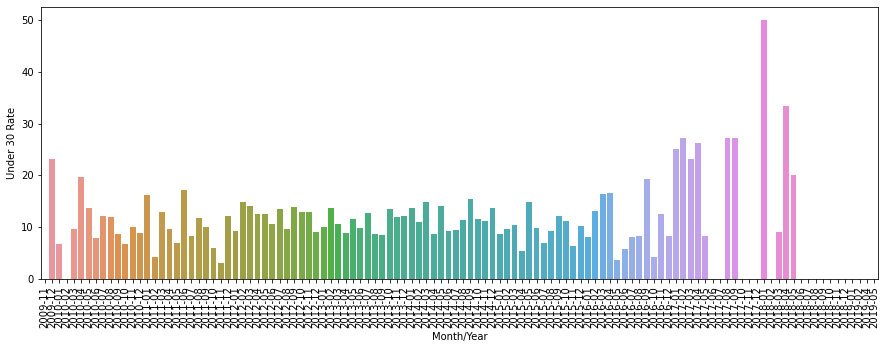

In [177]:
#WHY DOESN'T LINE PLOT WORK?

fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(data=rate_per_month, x='Month/Year', y='Under 30 Rate')
plt.xticks(rotation=90);

### 1b. By Condition?

In [113]:
#frequent fliers
by_patient = in_readmission.groupby('Patient ID')['Encounter Start Date'].count().reset_index()\
                    .rename({'Encounter Start Date':'Frequency of Readmission'}, axis=1)\
                    .sort_values('Frequency of Readmission', ascending=False)

In [117]:
#merge diagnoses with all readmission under-30 patients
discharge = hosp_admish[['Principal Discharge Diagnosis ICD-9-CM Description', 'Patient ID', 'Encounter End Date']]
discharge['Encounter End Date'] = pd.to_datetime(discharge['Encounter End Date'])
patient_conditions = discharge.merge(in_readmission, on=['Patient ID', 'Encounter End Date'])
patient_conditions = patient_conditions.groupby(['Patient ID','Principal Discharge Diagnosis ICD-9-CM Description'])['Encounter End Date']\
                        .count().reset_index().rename({'Encounter End Date':'Count of Diagnosis'}, axis=1)
patient_conditions = patient_conditions.sort_values('Count of Diagnosis', ascending=False)

#merge patient by diagnosis with patient by readmission for all relevant columns in one tidy df. Look for patterns in patients
read_by_patient = by_patient.merge(patient_conditions, on='Patient ID', how='left')
read_by_patient

<ipython-input-117-66b6344b73d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discharge['Encounter End Date'] = pd.to_datetime(discharge['Encounter End Date'])


Patient ID  Frequency of Readmission  \
0    DS1|12422                        10   
1    DS1|12422                        10   
2    DS1|21926                        10   
3    DS1|53241                         9   
4     DS1|3812                         8   
5     DS1|3812                         8   
6    DS1|13593                         8   
7     DS1|3663                         7   
8    DS1|36688                         7   
9    DS1|37477                         7   
10   DS1|10451                         7   
11   DS1|10451                         7   
12   DS1|10451                         7   
13   DS1|55609                         7   
14   DS1|48347                         7   
15   DS1|53921                         6   
16   DS1|53921                         6   
17    DS1|6506                         6   
18   DS1|54840                         6   
19   DS1|11785                         5   
20   DS1|11785                         5   
21   DS1|11785                         5   
22   DS1|11785                         5   
23   DS1|20461                         5   
24   DS1|20461                         5   
25   DS1|20461                         5   
26   DS1|37954                         5   
27   DS1|37954                         5   
28   DS1|26751                         5   
29   DS1|26751                         5   
30   DS1|26751                         5   
31   DS1|30393                         4   
32   DS1|24041                         4   
33   DS1|47885                         4   
34   DS1|35155                         4   
35   DS1|42969                         4   
36   DS1|51692                         4   
37   DS1|16409                         4   
38   DS1|39480                         4   
39   DS1|40290                         4   
40   DS1|40290                         4   
41   DS1|40290                         4   
42   DS1|19074                         4   
43   DS1|36886                         4   
44   DS1|12364                         4   
45   DS1|27407                         3   
46   DS1|50174                         3   
47   DS1|30949                         3   
48   DS1|47587                         3   
49   DS1|52751                         3   
50   DS1|33966                         3   
51   DS1|27596                         3   
52   DS1|27596                         3   
53   DS1|59707                         3   
54   DS1|32814                         3   
55   DS1|25797                         3   
56   DS1|48279                         3   
57   DS1|48279                         3   
58   DS1|48279                         3   
59    DS1|6139                         3   
60   DS1|31599                         3   
61   DS1|31599                         3   
62   DS1|31599                         3   
63   DS1|31493                         3   
64   DS1|31493                         3   
65   DS1|60619                         3   
66   DS1|49207                         3   
67   DS1|35660                         3   
68   DS1|25922                         3   
69   DS1|31199                         3   
70   DS1|16314                         3   
71   DS1|11581                         3   
72   DS1|11581                         3   
73   DS1|53976                         3   
74   DS1|53976                         3   
75   DS1|53976                         3   
76   DS1|23411                         3   
77   DS1|22069                         3   
78   DS1|15637                         3   
79    DS1|3750                         3   
80    DS1|3750                         3   
81    DS1|3750                         3   
82   DS1|12651                         3   
83   DS1|12651                         3   
84   DS1|25216                         2   
85   DS1|56584                         2   
86   DS1|24918                         2   
87   DS1|30763                         2   
88   DS1|25004                         2   
89   DS1|25778                         2   


In [122]:
#look for patterns in diagnoses
by_diagnosis = conditions.groupby('Principal Discharge Diagnosis ICD-9-CM Description')['Patient ID'].count().reset_index()\
                .rename({'Patient ID':'Count of Diagnosis'}, axis=1).sort_values('Count of Diagnosis', ascending=False)

by_diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 134 to 137
Data columns (total 2 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   Principal Discharge Diagnosis ICD-9-CM Description  138 non-null    object
 1   Count of Diagnosis                                  138 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


### 2. What percent of patients have a PCP visit within a week of discharge?

In [31]:
pc_visits.head()

Encounter ID Patient ID  \
0  COV|EE|DS1|10076|20110225|DS1|NPI|1487856779  DS1|10076   
1  COV|EE|DS1|10088|20140222|DS1|NPI|1528030996  DS1|10088   
2  COV|EE|DS1|10165|20140907|DS1|NPI|1477579365  DS1|10165   
3  COV|EE|DS1|10240|20130624|DS1|NPI|1821178088  DS1|10240   
4  COV|EE|DS1|10293|20160904|DS1|NPI|1609004191  DS1|10293   

  Service Provider ID Attending Provider ID Provider Group Provider ID  \
0  DS1|NPI|1487856779                   NaN         DS1|NPI|1043427248   
1  DS1|NPI|1528030996    DS1|NPI|1528030996         DS1|NPI|1043427248   
2  DS1|NPI|1477579365                   NaN         DS1|NPI|1043427248   
3  DS1|NPI|1821178088    DS1|NPI|1821178088         DS1|NPI|1407058787   
4  DS1|NPI|1609004191                   NaN         DS1|NPI|1184722779   

  Facility Provider ID Encounter Primary Payor ID Encounter Primary Plan ID  \
0                  NaN                      DS1|1                 DS1|5047W   
1   DS1|NPI|1902803315                      DS1|1                 DS1|5047W   
2                  NaN                      DS1|1                 DS1|5047W   
3   DS1|NPI|1104842020                      DS1|1                 DS1|5047W   
4                  NaN                      DS1|1                 DS1|5047X   

   Attending Provider NPI  Facility Provider NPI  Service Provider NPI  \
0                     NaN                    NaN          1.487857e+09   
1            1.528031e+09           1.902803e+09          1.528031e+09   
2                     NaN                    NaN          1.477579e+09   
3            1.821178e+09           1.104842e+09          1.821178e+09   
4                     NaN                    NaN          1.609004e+09   

   Provider Group NPI Encounter Date  \
0        1.043427e+09     2011-02-18   
1        1.043427e+09     2014-02-22   
2        1.043427e+09     2014-08-31   
3        1.407059e+09     2013-06-17   
4        1.184723e+09     2016-09-04   

   Is Qualifying Preventive Primary Care Service  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   Is Qualifying Primary Care Service Provider  \
0                                            1   
1                                            1   
2                                            1   
3                                            1   
4                                            1   

   Is Qualifying Primary Care Attending  \
0                                     0   
1                                     1   
2                                     0   
3                                     1   
4                                     0   

   Is Qualifying Primary Care Provider Group  \
0                                          0   
1                                          1   
2                                          0   
3                                          1   
4                                          0   

  Qualifying Preventive Primary Care HCPCS Code  
0                                           NaN  
1                                           NaN  
2                                           NaN  
3                                           NaN  
4                                           NaN

In [32]:
#limit columns, convert relevant ones to objects and Encounter Date to datetime
pcp_trips = pc_visits[['Patient ID', 'Attending Provider NPI', 'Facility Provider NPI', 'Provider Group NPI', 'Encounter Date']]
pcp_trips = pcp_trips.astype(object)
pcp_trips['Encounter Date'] = pd.to_datetime(pcp_trips['Encounter Date'])
pcp_trips = pcp_trips.rename({'Encounter Date':'PCP Date'}, axis=1)
pcp_trips.head()


Patient ID Attending Provider NPI Facility Provider NPI Provider Group NPI  \
0  DS1|10076                    NaN                   NaN       1043427248.0   
1  DS1|10088           1528030996.0          1902803315.0       1043427248.0   
2  DS1|10165                    NaN                   NaN       1043427248.0   
3  DS1|10240           1821178088.0          1104842020.0       1407058787.0   
4  DS1|10293                    NaN                   NaN       1184722779.0   

    PCP Date  
0 2011-02-18  
1 2014-02-22  
2 2014-08-31  
3 2013-06-17  
4 2016-09-04

In [33]:
#merge hospital stays and pcp visits on patient ID; there are many duplicates
hosp_and_pcp_dates = hosp_stay.merge(pcp_trips, on='Patient ID', )
#hosp_and_pcp_dates = hosp_and_pcp_dates.drop_duplicates(subset=['Encounter Start Date','Encounter End Date'])
hosp_and_pcp_dates = hosp_and_pcp_dates.drop(columns=['Attending Provider NPI_y','Facility Provider NPI_y'])
hosp_and_pcp_dates

Patient ID Encounter Start Date Encounter End Date  \
0      DS1|10033           2013-01-12         2013-01-14   
1      DS1|10033           2013-01-12         2013-01-14   
2      DS1|10033           2013-01-12         2013-01-14   
3      DS1|10033           2013-01-12         2013-01-14   
4      DS1|10033           2013-01-12         2013-01-14   
...          ...                  ...                ...   
43786   DS1|9994           2015-11-24         2015-11-27   
43787   DS1|9994           2015-11-24         2015-11-27   
43788   DS1|9994           2015-11-24         2015-11-27   
43789   DS1|9994           2015-11-24         2015-11-27   
43790   DS1|9994           2015-11-24         2015-11-27   

      Attending Provider NPI_x Facility Provider NPI_x Month/Year  \
0                 1417170523.0              1306890389    2013-01   
1                 1417170523.0              1306890389    2013-01   
2                 1417170523.0              1306890389    2013-01   
3                 1417170523.0              1306890389    2013-01   
4                 1417170523.0              1306890389    2013-01   
...                        ...                     ...        ...   
43786             1750544516.0              1689608150    2015-11   
43787             1750544516.0              1689608150    2015-11   
43788             1750544516.0              1689608150    2015-11   
43789             1750544516.0              1689608150    2015-11   
43790             1750544516.0              1689608150    2015-11   

      Provider Group NPI   PCP Date  
0           1043427248.0 2015-12-08  
1           1043427248.0 2012-06-18  
2           1043427248.0 2014-06-10  
3           1043427248.0 2014-09-28  
4           1043427248.0 2014-03-16  
...                  ...        ...  
43786       1407058787.0 2015-06-22  
43787       1407058787.0 2015-12-05  
43788       1407058787.0 2015-12-13  
43789       1205884392.0 2014-05-18  
43790       1043427248.0 2013-07-20  

[43791 rows x 8 columns]

In [34]:
#THIS IS A GOOD DEMONSTRATION OF ALL THE RECORDS OF ONE PATIENT AFTER A MERGE (WITH MULTIPLE ADMISSIONS AND PCP VISITS)
# patient = hosp_and_pcp_dates[hosp_and_pcp_dates['Patient ID'] == 'DS1|10451']
# patient

In [35]:
#create column to show how many days between by subtracing PCP visit date from hospital end date
hosp_and_pcp_dates['Days Between'] = hosp_and_pcp_dates['PCP Date'] - hosp_and_pcp_dates['Encounter End Date']
#hosp_and_pcp_dates

#THIS GIVES A BOOLEAN VALUE INSTEAD. BUT HOW TO FILTER OUT NEGATIVES?
# hosp_and_pcp_dates['Under 7 Days'] = hosp_and_pcp_dates['Days Between'] <= dt.timedelta(days = 7)
# hosp_and_pcp_dates

#create column to say whether 7 days or less between those dates with for loop.
x = []

for i in hosp_and_pcp_dates['Days Between']:
    if (i <= dt.timedelta(days=7)) and (i >= dt.timedelta(days=0)) :
        x.append('yes')
    else:
        x.append('no')

hosp_and_pcp_dates['Under 7 Days'] = x

hosp_and_pcp_dates


Patient ID Encounter Start Date Encounter End Date  \
0      DS1|10033           2013-01-12         2013-01-14   
1      DS1|10033           2013-01-12         2013-01-14   
2      DS1|10033           2013-01-12         2013-01-14   
3      DS1|10033           2013-01-12         2013-01-14   
4      DS1|10033           2013-01-12         2013-01-14   
...          ...                  ...                ...   
43786   DS1|9994           2015-11-24         2015-11-27   
43787   DS1|9994           2015-11-24         2015-11-27   
43788   DS1|9994           2015-11-24         2015-11-27   
43789   DS1|9994           2015-11-24         2015-11-27   
43790   DS1|9994           2015-11-24         2015-11-27   

      Attending Provider NPI_x Facility Provider NPI_x Month/Year  \
0                 1417170523.0              1306890389    2013-01   
1                 1417170523.0              1306890389    2013-01   
2                 1417170523.0              1306890389    2013-01   
3                 1417170523.0              1306890389    2013-01   
4                 1417170523.0              1306890389    2013-01   
...                        ...                     ...        ...   
43786             1750544516.0              1689608150    2015-11   
43787             1750544516.0              1689608150    2015-11   
43788             1750544516.0              1689608150    2015-11   
43789             1750544516.0              1689608150    2015-11   
43790             1750544516.0              1689608150    2015-11   

      Provider Group NPI   PCP Date Days Between Under 7 Days  
0           1043427248.0 2015-12-08    1058 days           no  
1           1043427248.0 2012-06-18    -210 days           no  
2           1043427248.0 2014-06-10     512 days           no  
3           1043427248.0 2014-09-28     622 days           no  
4           1043427248.0 2014-03-16     426 days           no  
...                  ...        ...          ...          ...  
43786       1407058787.0 2015-06-22    -158 days           no  
43787       1407058787.0 2015-12-05       8 days           no  
43788       1407058787.0 2015-12-13      16 days           no  
43789       1205884392.0 2014-05-18    -558 days           no  
43790       1043427248.0 2013-07-20    -860 days           no  

[43791 rows x 10 columns]

In [36]:
hosp_and_pcp_dates['Under 7 Days'].value_counts()

no     41416
yes     2375
Name: Under 7 Days, dtype: int64

In [225]:
under_seven = hosp_and_pcp_dates[hosp_and_pcp_dates['Under 7 Days'] == 'yes']

#unique visits (1864)
under_seven = under_seven.drop_duplicates(subset=['Encounter Start Date','Encounter End Date','Patient ID'])

#unique patients (1678)
# under_seven = under_seven.drop_duplicates(subset=['Patient ID'])
under_seven

Patient ID Encounter Start Date Encounter End Date  \
17     DS1|10043           2014-01-05         2014-01-12   
28     DS1|10073           2012-06-13         2012-06-21   
50     DS1|10101           2012-12-06         2012-12-09   
229    DS1|10303           2012-06-21         2012-06-24   
245    DS1|10305           2014-05-10         2014-05-12   
248    DS1|10325           2012-07-06         2012-07-07   
251    DS1|10343           2010-02-23         2010-03-03   
282    DS1|10411           2015-02-24         2015-02-26   
284    DS1|10415           2012-08-19         2012-08-20   
297    DS1|10423           2014-12-24         2014-12-27   
301    DS1|10436           2015-02-20         2015-02-23   
356    DS1|10451           2013-04-16         2013-04-26   
371    DS1|10451           2013-05-01         2013-05-09   
379    DS1|10451           2013-06-25         2013-07-01   
450    DS1|10451           2014-05-23         2014-05-29   
493    DS1|10507           2012-11-10         2012-11-16   
502    DS1|10507           2012-11-20         2012-11-27   
509    DS1|10515           2018-08-06         2018-08-09   
515    DS1|10520           2011-07-07         2011-07-10   
546    DS1|10522           2012-10-31         2012-11-02   
600    DS1|10698           2012-01-04         2012-01-05   
611    DS1|10698           2012-01-03         2012-01-04   
694    DS1|10734           2010-04-25         2010-04-28   
719    DS1|10734           2010-05-17         2010-05-21   
832    DS1|10750           2010-08-17         2010-08-19   
876    DS1|10750           2011-07-11         2011-07-14   
921    DS1|10798           2012-04-30         2012-05-03   
924    DS1|10809           2014-05-16         2014-05-21   
939    DS1|10843           2014-12-16         2014-12-24   
969    DS1|10862           2010-11-04         2010-11-06   
984     DS1|1088           2013-12-30         2014-01-01   
999    DS1|10905           2010-08-22         2010-08-29   
1021   DS1|10926           2014-08-03         2014-08-05   
1047   DS1|11014           2015-03-19         2015-03-22   
1054   DS1|11031           2012-10-04         2012-10-07   
1072   DS1|11062           2012-04-28         2012-05-02   
1084   DS1|11071           2012-08-18         2012-08-21   
1133   DS1|11089           2011-04-05         2011-04-07   
1236   DS1|11089           2012-02-22         2012-03-02   
1286   DS1|11092           2011-02-26         2011-02-28   
1297   DS1|11098           2011-09-24         2011-09-28   
1299   DS1|11106           2010-10-09         2010-10-11   
1336   DS1|11267           2012-06-18         2012-06-20   
1361   DS1|11304           2011-01-09         2011-01-13   
1367   DS1|11307           2013-10-23         2013-10-25   
1369   DS1|11316           2014-12-07         2014-12-10   
1435   DS1|11364           2018-03-24         2018-03-26   
1465   DS1|11374           2013-04-13         2013-04-16   
1496   DS1|11416           2010-05-31         2010-06-02   
1530   DS1|11432           2012-04-08         2012-04-11   
1565   DS1|11446           2013-07-13         2013-07-15   
1573   DS1|11465           2013-09-12         2013-09-14   
1679   DS1|11519           2011-12-23         2011-12-26   
1731   DS1|11581           2013-09-22         2013-09-25   
1784   DS1|11581           2013-12-21         2013-12-24   
1825   DS1|11621           2012-06-10         2012-06-12   
1850   DS1|11635           2013-07-05         2013-07-07   
1874   DS1|11738           2012-12-21         2012-12-22   
1893   DS1|11750           2011-10-31         2011-11-03   
1896   DS1|11756           2014-05-25         2014-05-30   
1985    DS1|1180           2014-06-23         2014-06-24   
2008    DS1|1187           2012-07-31         2012-08-03   
2027   DS1|11889           2011-09-28         2011-09-30   
2038   DS1|11891           2011-02-25         2011-03-01   
2045   DS1|11891           2011-03-03         2011-03-05   
2053   DS1|11912           2012-11-30         

In [38]:
pcp_rate = round((len(under_seven)/len(hosp_stay))*100,2)
pcp_rate

30.0

### 3. Do either vary by individual or group PCP's?

#### 3a. What are the rates of Under-30 by hospital?

In [124]:
#I REALIZE THIS DOESN'T CALCULATE READMISSION RATE BY HOSPITAL, BUT PERCENTAGE OF UNDER-30 THAT COMES FROM EACH HOSPITAL
#(PROBABLY NOT A GREAT ANSWER BECAUSE IT DOESN'T ACCOUNT FOR HOSPITAL VOLUME)
#Group by hospital NPI, sort values, plot
read_by_hospital = in_readmission.groupby('Facility Provider NPI')['Patient ID'].count().reset_index().sort_values('Patient ID',ascending=False)
read_by_hospital = read_by_hospital.rename({'Patient ID':'Count of Readmissions','Facility Provider NPI':'Hospital'},axis=1)
read_by_hospital['Percentage of Readmissions Under 30 Days'] = round((read_by_hospital['Count of Readmissions']/read_by_hospital['Count of Readmissions'].sum())*100,2)
read_by_hospital.head()

Hospital  Count of Readmissions  \
21  1184722779                    115   
37  1427055839                    107   
80  1902803315                    101   
58  1689772592                     83   
64  1710918545                     50   

    Percentage of Readmissions Under 30 Days  
21                                     16.52  
37                                     15.37  
80                                     14.51  
58                                     11.93  
64                                      7.18

In [100]:
read_by_hospital['Count of Readmissions'].sum()

696

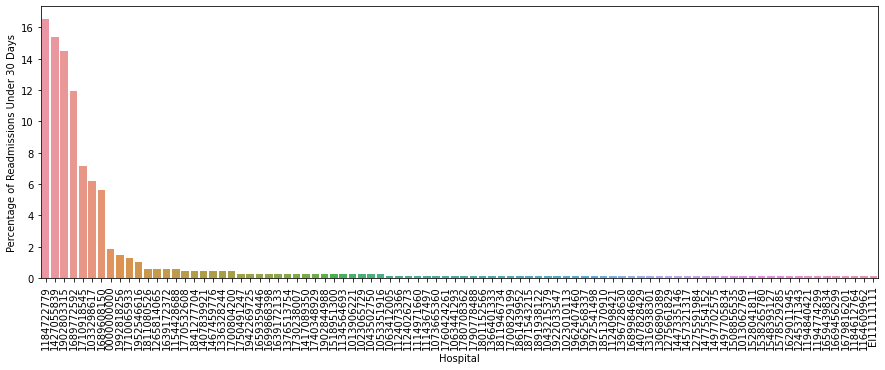

In [45]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(data=read_by_hospital, x='Hospital', y='Percentage of Readmissions Under 30 Days')
plt.xticks(rotation=90);

In [180]:
#count admissions per hospital
stay_per_hospital = hosp_stay.groupby('Facility Provider NPI')['Patient ID'].count().reset_index().sort_values('Patient ID',ascending=False)
stay_per_hospital = stay_per_hospital.rename({'Patient ID':'Count of Admissions','Facility Provider NPI':'Hospital'}, axis=1)
stay_per_hospital.head(20)


Hospital  Count of Admissions
185  1902803315                 1204
46   1184722779                 1196
91   1427055839                  889
139  1689772592                  679
12   1033298617                  460
146  1710918545                  436
138  1689608150                  340
144  1710065933                  109
0    0000000000                  103
210  1992818256                   87
40   1154428688                   27
186  1902844988                   26
165  1811080526                   22
44   1174667158                   21
131  1639172372                   20
158  1780668434                   17
68   1306890389                   16
34   1124026273                   16
97   1467459776                   16
9    1023065729                   12

In [56]:
#Calculate % Readmissions Under 30 days by hospital by merging grouped admissions with grouped readmissions, calculating percent
rates_by_hosp = stay_per_hospital.merge(read_by_hospital,on='Hospital')
rates_by_hosp = rates_by_hosp.drop(columns='Percentage of Readmissions Under 30 Days')
rates_by_hosp['% Readmissions Under 30 days'] = round((rates_by_hosp['Count of Readmissions']/
                                                      rates_by_hosp['Count of Admissions'])*100,2)
rates_by_hosp.sort_values('% Readmissions Under 30 days',ascending=False)
rates_by_hosp

Hospital  Count of Admissions  Count of Readmissions  \
89  1194840421                    1                      1   
78  1548393127                    1                      1   
67  1376513754                    2                      2   
69  1013062769                    1                      1   
70  1851370910                    1                      1   
..         ...                  ...                    ...   
0   1902803315                 1204                    101   
7   1710065933                  109                      9   
11  1902844988                   26                      2   
14  1306890389                   16                      1   
15  1124026273                   16                      1   

    % Readmissions Under 30 days  
89                        100.00  
78                        100.00  
67                        100.00  
69                        100.00  
70                        100.00  
..                           ...  
0                           8.39  
7                           8.26  
11                          7.69  
14                          6.25  
15                          6.25  

[90 rows x 4 columns]

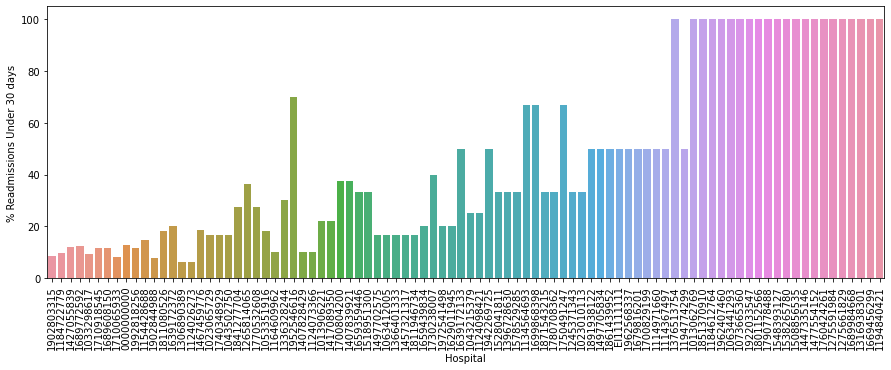

In [48]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(data=rates_by_hosp, x='Hospital', y='% Readmissions Under 30 days')
plt.xticks(rotation=90);

#### 3b. What are the rates of Under 30 by group PCP?

In [54]:
#calculate how many patients go to each group. calculate how many of those patients have had under-30 day readmissions
provider_groups = pc_visits.groupby('Provider Group NPI')['Encounter ID'].count().reset_index()
provider_groups['Provider Group NPI'] = provider_groups['Provider Group NPI'].astype(str)
provider_groups = provider_groups.rename({'Encounter ID':'Patient Count'},axis=1)
provider_groups

Provider Group NPI  Patient Count
0                  0.0             52
1         1003833179.0              2
2         1003864174.0             61
3         1003864182.0              1
4         1003896648.0            427
..                 ...            ...
375       1982752515.0              1
376       1992027593.0              5
377       1992804462.0              1
378       1992897508.0             10
379       1992930986.0            472

[380 rows x 2 columns]

### Bonus:
### 4. Which individual or PCP groups should we make an extra effort with to build a relationship? Which have the highest volume

### 5. What percent of our patients do not have a PCP assigned or haven't seen their PCP recently?

### 6. Are there certain patients we should focus on (e.g. frequent fliers)?

### 7. From this, what could a version 1 of an actionable dashboard or intervention list look like to support the Transition Care Managers?